In [48]:
import itertools as it
import math
from collections import Counter
from sympy import Matrix, Rational, eye, sqrt, symbols, expand, re, im, N
from functools import lru_cache
import networkx as nx
import numpy as np
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt
import networkx as nx


from activation_funcs import *

In [56]:
# ============================================================
# 1. Combinatorial helpers (fast class enumeration)
# ============================================================

def integer_partitions(n):
    """Generate integer partitions of n in nonincreasing order."""
    def gen(n, max_part):
        if n == 0:
            yield ()
            return
        for x in range(min(n, max_part), 0, -1):
            for rest in gen(n - x, x):
                yield (x,) + rest
    return list(gen(n, n))

def class_size_from_type(n, part):
    """
    Class size = n! / (Π_i (m_i! * i^{m_i}))
    where m_i = multiplicity of i in part.
    """
    mult = Counter(part)
    denom = 1
    for i, m in mult.items():
        denom *= math.factorial(m) * (i**m)
    return math.factorial(n) // denom

def conjugacy_class_reps(n):
    """
    Return [{type:part, size:int}] without enumerating permutations.
    """
    return [{"type": part, "size": class_size_from_type(n, part)} for part in integer_partitions(n)]

# ============================================================
# 2. k-subset permutation representation (using NumPy)
# ============================================================

def k_subsets(n, k):
    if k < 0 or k > n:
        return []
    return [tuple(c) for c in it.combinations(range(n), k)]

def perm_matrix_from_cycles(n, k, cycles):
    """
    Build ρ(σ) as a NumPy array.
    """
    Xk = k_subsets(n, k)
    idx = {A:i for i,A in enumerate(Xk)}
    m = len(Xk)
    # Use a NumPy array for performance
    M = np.zeros((m, m), dtype=np.float64)

    # build permutation map
    perm_map = list(range(n))
    for cyc in cycles:
        cyc = list(cyc)
        L = len(cyc)
        for t in range(L):
            perm_map[cyc[t]] = cyc[(t+1)%L]

    for j,A in enumerate(Xk):
        B = tuple(sorted(perm_map[a] for a in A))
        i = idx[B]
        M[i, j] = 1.0  # Use NumPy's [row, col] indexing
    return M

def canonical_cycles_from_type(part):
    """
    Construct one canonical cycle decomposition for a given cycle-type partition.
    Example: (3,2) -> [(0,1,2), (3,4)]
    """
    cycles = []
    current = 0
    for L in part:
        cyc = tuple(range(current, current+L))
        cycles.append(cyc)
        current += L
    return cycles

# ============================================================
# 3. Character evaluation (symbolic, cached, but returns float)
# ============================================================

# We still need sympy for this one part (polynomial expansion)
from sympy import symbols, expand, Rational

@lru_cache(None)
def chi_two_row(n, i, cycle_type_part):
    """
    χ^{(n-i,i)}(σ) = π_{n,i}(σ) - π_{n,i-1}(σ)
    Returns a float, not a sympy object.
    """
    x = symbols('x')
    c = Counter(cycle_type_part)
    a = {m: c.get(m,0) for m in range(1, n+1)}
    P = 1
    for m, am in a.items():
        if am:
            P *= (1 + x**m)**am
    P = expand(P)
    def coeff(k): return P.coeff(x, k)
    
    # Calculate the exact rational value
    val = Rational(1) if i==0 else coeff(i) - coeff(i-1)
    
    # Return as a float for numerical computation
    return float(val)

def dim_two_row(n, i):
    if i < 0 or i > n:
        return 0
    if i == 0:
        return 1
    return math.comb(n, i) - math.comb(n, i-1)

# ============================================================
# 4. Central idempotents (Robust Numerical Version)
# ============================================================

def projectors_two_row(n, k, tol=1e-8):
    """
    Numerically stable version using NumPy.
    Finds Qblocks (orthonormal bases for irrep subspaces)
    using np.linalg.eigh.
    """
    basis = k_subsets(n, k)
    m = len(basis)
    if m == 0: # Handle edge cases like k > n
        return {}, {i: np.array([[]]).reshape((0, 0)) for i in range(k+1)}, basis

    proj, Qblocks = {}, {}
    classes = conjugacy_class_reps(n)
    
    # Build cache of rho matrices as NumPy arrays
    rho_cache = {}
    for C in classes:
        cycles = canonical_cycles_from_type(C["type"])
        rho_cache[tuple(C["type"])] = perm_matrix_from_cycles(n, k, cycles)

    for i in range(0, k+1):
        dimL = dim_two_row(n, i)
        
        if dimL == 0:
            # Create an empty (m x 0) matrix placeholder
            Qblocks[i] = np.empty((m, 0), dtype=np.float64)
            proj[i] = np.zeros((m, m), dtype=np.float64)
            continue

        # M will be a float NumPy array
        M = np.zeros((m, m), dtype=np.float64)
        
        for C in classes:
            mu = C["type"]
            # chi_val is now a float
            chi_val = chi_two_row(n, i, mu)
            # S_C is a NumPy array
            S_C = rho_cache[tuple(mu)]
            # This is fast NumPy array arithmetic
            M += C["size"] * chi_val * S_C

        # p is a NumPy array. The prefactor is a standard float.
        prefactor = float(dimL) / math.factorial(n)
        p = prefactor * M

        # Symmetrize to ensure numerical stability for eigh
        p = (p + p.T) / 2.0
        proj[i] = p # Save the projector matrix

        # --- NEW ROBUST BASIS CALCULATION ---
        # Use np.linalg.eigh (eigensolver for symmetric/hermitian)
        # It's fast, stable, and returns ORTHONORMAL eigenvectors.
        try:
            eigenvalues, eigenvectors = np.linalg.eigh(p)
        except np.linalg.LinAlgError:
            print(f"Warning: Eigendecomposition failed for n={n}, k={k}, i={i}")
            Qblocks[i] = np.empty((m, 0), dtype=np.float64)
            continue

        # Select eigenvectors whose eigenvalue is close to 1
        # 'eigenvectors' has eigenvectors as COLUMNS
        eig1_indices = np.where(np.abs(eigenvalues - 1.0) < tol)[0]
        eig1_vecs = eigenvectors[:, eig1_indices]

        # Sanity check dimension
        if eig1_vecs.shape[1] != dimL:
            print(f"Warning: n={n}, k={k}, i={i}. Expected dim {dimL}, found {eig1_vecs.shape[1]}")
            # If we found *more* vectors than expected (due to noise),
            # truncate to the correct dimension.
            if eig1_vecs.shape[1] > dimL:
                 Qblocks[i] = eig1_vecs[:, :dimL]
            else:
                 # If we found fewer, this is a numerical issue,
                 # but we'll use what we found.
                 Qblocks[i] = eig1_vecs
        else:
            Qblocks[i] = eig1_vecs
        
        # NO Gram-Schmidt needed. `eigh` guarantees orthonormality.
        # --- END NEW ROBUST BASIS CALCULATION ---

    return proj, Qblocks, basis

# ============================================================
# 5. Fourier utilities (using NumPy)
# ============================================================

def assemble_Q(Qblocks):
    """Assembles the full change-of-basis matrix Q."""
    # Use np.hstack
    return np.hstack([Qblocks[i] for i in sorted(Qblocks.keys())])

# ============================================================
# 6. Interaction graph (using NumPy)
# ============================================================

def build_decompositions(n, K_max):
    # This function just calls the updated projector function
    # return {k: {"Qblocks": projectors_two_row(n,k)[1]} for k in range(K_max+1)}
    return {k: {"Qblocks": projectors_two_row_spectral(n,k)[1]} for k in range(K_max+1)}


def canonical_irrep_blocks(decomps):
    irreps = {}
    for k, data in decomps.items():
        for i, Qki in data["Qblocks"].items():
            if i not in irreps:
                # Store the NumPy array
                irreps[i] = {"Q": Qki, "k_source": k,
                             "dim": Qki.shape[1], "ambient_dim": Qki.shape[0]}
    return irreps

def test_edge_activation(irreps, i, j, activation_fn, tol=1e-8):
    """
    Deterministic test using NumPy.
    """
    Qi = irreps[i]["Q"]  # numpy array (ambient_dim x dim_i)
    Qj = irreps[j]["Q"]  # numpy array (ambient_dim x dim_j)

    # they must live in the same ambient representation space
    if Qi.shape[0] != Qj.shape[0]:
        return False
        
    dim_i = Qi.shape[1]
    if dim_i == 0: # No source vectors
        return False

    # Vectorize the activation function for fast application
    v_activation_fn = np.vectorize(activation_fn)

    # --- helper: project after activation ---
    def project_and_check(v):
        """Apply activation and check projection onto L_j."""
        # v is a numpy array
        v_act = v_activation_fn(v)
        
        # Use numpy's @ operator for matrix/vector multiplication
        # This computes the projection coefficients
        coeffs_j = Qj.T @ v_act
        
        # Use numpy's 'any' for a fast check
        return np.any(np.abs(coeffs_j) > tol)

    # --- 1. test each individual basis vector ---
    for r in range(dim_i):
        v = Qi[:, r] # This is a 1D numpy array
        if project_and_check(v):
            return True

    # --- 2. test pairwise sums of distinct basis vectors ---
    for a, b in combinations(range(dim_i), 2):
        v_sum = Qi[:, a] + Qi[:, b] # Fast numpy vector addition
        if project_and_check(v_sum):
            return True

    # nothing leaked into L_j
    return False


def build_simple_irrep_interaction_graph(n, activation_fn, K_max=None, tol=1e-8):
    """
    High-level orchestration function (mostly unchanged)
    """
    if K_max is None:
        K_max = n // 2 # A more sensible default
    
    print(f"Building decompositions for n={n}, k=0..{K_max}")
    # 1. build decompositions for each k
    decomps = {}
    for k in range(K_max+1):
        # _, Qblocks, _ = projectors_two_row(n,k, tol=tol)
        _, Qblocks, _ = projectors_two_row_spectral(n,k, tol=tol)

        decomps[k] = Qblocks

    print("Extracting canonical irrep blocks...")
    # 2. pick canonical irrep data
    irreps = {}
    for k, Qblocks in decomps.items():
        for i, Qi in Qblocks.items():
            if Qi.shape[1] == 0: # Skip empty irreps
                continue
            if i not in irreps:
                irreps[i] = {
                    "Q": Qi,
                    "k_source": k,
                    "dim": Qi.shape[1],
                    "ambient_dim": Qi.shape[0],
                }

    # 3. group irreps by which carrier space they came from
    by_k = {}
    for i, meta in irreps.items():
        ksrc = meta["k_source"]
        by_k.setdefault(ksrc, []).append(i)

    print("Testing all pairwise interactions...")
    # 4. build directed graph
    G = nx.DiGraph()
    for i in irreps.keys():
        G.add_node(i)

    for ksrc, irr_list in by_k.items():
        if not irr_list:
            continue
        print(f"  Testing interactions in k={ksrc} space...")
        for a in irr_list:
            for b in irr_list:
                if test_edge_activation(irreps, a, b, activation_fn, tol=tol):
                    G.add_edge(a, b, carrier_k=ksrc)

    print("Done.")
    return G, irreps


def visualize_irrep_graph(G, title="Irrep interaction graph"):
    """
    Visualization (unchanged)
    """
    pos = nx.spring_layout(G, seed=42, k=0.5)
    labels = {i: f"(n-{i},{i})" for i in G.nodes()}
    
    plt.figure(figsize=(8,8))
    
    # Get unique carrier_k values for coloring
    edges = G.edges(data=True)
    k_values = sorted(list(set(d['carrier_k'] for _, _, d in edges)))
    colors = plt.cm.viridis(np.linspace(0, 1, len(k_values)))
    k_color_map = {k: c for k, c in zip(k_values, colors)}
    
    edge_colors = [k_color_map[d['carrier_k']] for _, _, d in edges]

    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1500,
                           edgecolors='black')
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight='bold')
    
    if edge_colors:
        nx.draw_networkx_edges(G, pos, arrows=True, arrowsize=20, 
                               width=2, edge_color=edge_colors,
                               connectionstyle='arc3,rad=0.1')
    else:
        nx.draw_networkx_edges(G, pos, arrows=True, arrowsize=20, width=2,
                               connectionstyle='arc3,rad=0.1')
        
    edge_labels = {(u,v): f"k={G[u][v]['carrier_k']}" for u,v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,
                                 font_color='red', font_size=8)
    
    plt.title(title)
    plt.axis('off')
    plt.show()

In [49]:
def get_johnson_adjacency_matrix(n, k, basis):
    """
    Builds the adjacency matrix A for the Johnson graph J(n,k).
    
    A[i,j] = 1 if |basis[i] intersect basis[j]| == k-1
    """
    m = len(basis)
    if m == 0:
        return np.array([[]], dtype=np.float64)
        
    A = np.zeros((m, m), dtype=np.float64)
    
    # Use sets for fast intersection
    basis_sets = [set(s) for s in basis]
    
    for i in range(m):
        for j in range(i + 1, m):
            # Check for adjacency: intersection size is k-1
            intersection_size = len(basis_sets[i].intersection(basis_sets[j]))
            if intersection_size == k - 1:
                A[i, j] = 1.0
                A[j, i] = 1.0
    return A

def projectors_two_row_spectral(n, k, tol=1e-8):
    """
    Finds the irrep bases (Qblocks) using the spectral decomposition
    of the Johnson graph J(n,k) adjacency matrix.
    
    This is faster and more numerically stable than the
    character projector method.
    """
    basis = k_subsets(n, k)
    m = len(basis)
    Qblocks = {}

    if m == 0:
        for i in range(k + 1):
            Qblocks[i] = np.empty((0, 0), dtype=np.float64)
        return Qblocks, basis

    # 1. Build the commuting operator
    A = get_johnson_adjacency_matrix(n, k, basis)

    # 2. Get its eigenspaces (which are the irrep subspaces)
    try:
        eigenvalues, eigenvectors = np.linalg.eigh(A)
    except np.linalg.LinAlgError:
        print(f"Warning: Spectral Eigendecomposition failed for n={n}, k={k}")
        for i in range(k + 1):
            Qblocks[i] = np.empty((m, 0), dtype=np.float64)
        return Qblocks, basis
    
    # 3. Group eigenvectors by their known theoretical eigenvalues
    for i in range(0, k + 1):
        dimL = dim_two_row(n, i)
        if dimL == 0:
            Qblocks[i] = np.empty((m, 0), dtype=np.float64)
            continue
            
        # This is the known theoretical eigenvalue for the L_(n-i, i) subspace
        target_eigenvalue = (k - i) * (n - k - i) - i
        
        eig_indices = np.where(np.abs(eigenvalues - target_eigenvalue) < tol)[0]
        eig_vecs = eigenvectors[:, eig_indices]
        
        # Dimension check
        if eig_vecs.shape[1] != dimL:
            print(f"Warning: n={n}, k={k}, i={i}. Expected dim {dimL}, found {eig_vecs.shape[1]}")
            # Truncate if we found too many (due to numerical noise)
            if eig_vecs.shape[1] > dimL:
                Qblocks[i] = eig_vecs[:, :dimL]
            # Pad if we found too few (this is bad, but better than crashing)
            else:
                Qblocks[i] = np.zeros((m, dimL), dtype=np.float64)
                Qblocks[i][:, :eig_vecs.shape[1]] = eig_vecs
        else:
            Qblocks[i] = eig_vecs

    # We don't return the projectors 'proj' anymore, just the Qblocks
    return None, Qblocks, basis

Building decompositions for n=5, k=0..2
Extracting canonical irrep blocks...
Testing all pairwise interactions...
  Testing interactions in k=0 space...
  Testing interactions in k=1 space...
  Testing interactions in k=2 space...
Done.

Irrep Interaction Graph for S_5, k<=None, activation=RELU
Nodes: [0, 1, 2]
Edges: [(0, 0, {'carrier_k': 0}), (1, 1, {'carrier_k': 1}), (2, 2, {'carrier_k': 2})]


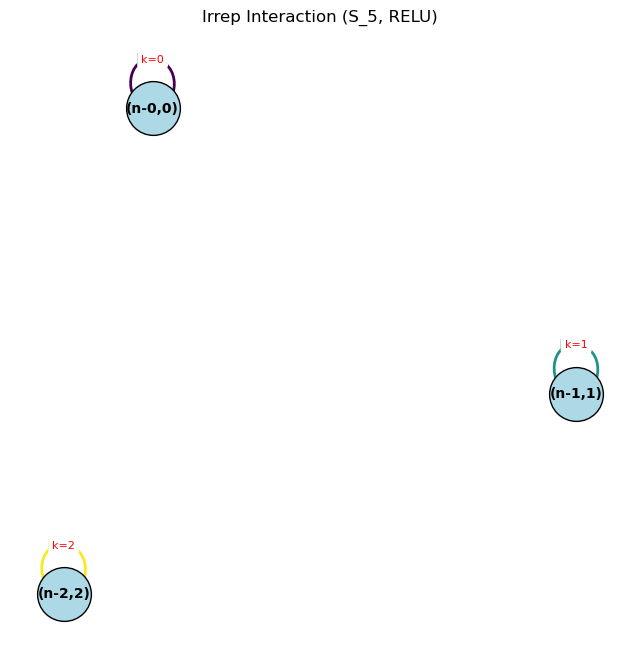

In [68]:
N, activtion_func, K = 5, RELU, None

G, irreps = build_simple_irrep_interaction_graph(
    n=N, 
    activation_fn=activtion_func, 
    K_max=K,
    tol=1e-8
)

print(f"\nIrrep Interaction Graph for S_{N}, k<={K}, activation={RELU.__name__}")
print(f"Nodes: {list(G.nodes())}")
print(f"Edges: {list(G.edges(data=True))}")

visualize_irrep_graph(G, 
    title=f"Irrep Interaction (S_{N}, {activtion_func.__name__})")